In [1]:
import pandas as pd
df = pd.read_csv("mortgage_data/sample_2020/TTD.csv")

/var/folders/g2/byydgcq968178bg657rkq50h0000gn/T/ipykernel_72658/4133179741.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


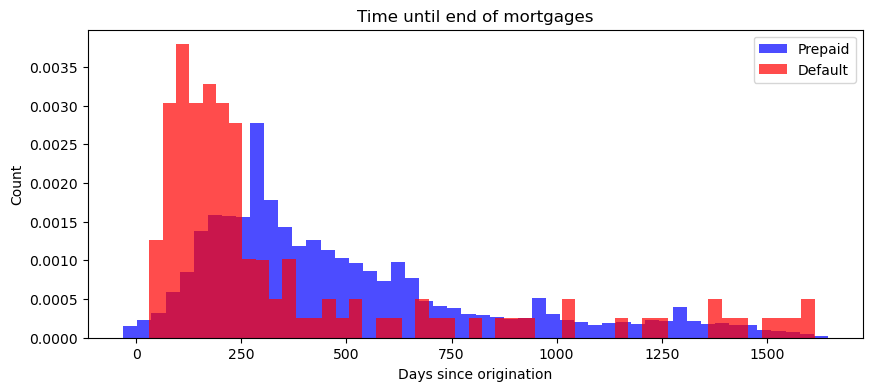

In [6]:
X1 = df[df["Event"] == "Prepaid"]
X2 = df[df["Event"] == "Default"]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.set_title("Time until end of mortgages")
ax.set_xlabel("Days since origination"); ax.set_ylabel("Count")
ax.hist(X1["TTD"], bins=50, color="blue", alpha=0.7, density=True, label="Prepaid")
ax.hist(X2["TTD"], bins=50, color="red", alpha=0.7, density=True, label="Default")

ax.legend()
fig.show()

In [ ]:
from copulas.bivariate import Clayton
import numpy as np
from scipy.stats import weibull_min

t = np.hstack([X1["TTD"].values, X2["TTD"].values])
i = np.hstack([np.zeros(len(X1)), np.ones(len(X2))])

def weibull_pdf(t, lmbda, k):
    return (k / lmbda) * (t / lmbda)**(k - 1) * np.exp(-(t / lmbda)**k)

def weibull_sf(t, lmbda, k):
    return np.exp(-(t / lmbda)**k)

def partial_derivative(u1, u2, theta):
    A = np.power(u2, -theta - 1)
    if (A == np.inf).any():
        return np.zeros(len(u2))

    B = np.power(u2, -theta) + np.power(u1, -theta) - 1
    h = np.power(B, (-1 - theta) / theta)
    return A * h

def neg_log_likelihood(params):
    theta, lmbda1, k1, lmbda2, k2 = params
    if lmbda1 <= 0 or k1 <= 0 or lmbda2 <= 0 or k2 <= 0:
        return np.inf
    
    copula = Clayton()
    copula.theta = theta

    u1 = weibull_min.cdf(t, c=k1, scale=lmbda1)
    u2 = weibull_min.cdf(t, c=k2, scale=lmbda2)

    f1 = weibull_pdf(t, lmbda=lmbda1, k=k1) * partial_derivative(u1, u2, theta)
    f2 = weibull_pdf(t, lmbda=lmbda2, k=k2) * partial_derivative(u2, u1, theta)

    likelihoods = np.where(i == 0, f1, f2)
    likelihoods = np.clip(likelihoods, 1e-10, None)
    return -np.sum(np.log(likelihoods))

from scipy.optimize import minimize
from itertools import product

values = np.arange(1.0, 4.5, 1.0)
initial_guess = [5.0, 500, 2.0, 500, 2.0]
bounds = [(1, 10), (1, None), (1, 10), (1, None), (1, 10)]

best_result = None

for lr in [1e-3, 1e-5, 1e-7, 1e-9]:
    result = minimize(lambda x: neg_log_likelihood(x) * lr, initial_guess, bounds=bounds)
    result.fun = result.fun * (1/lr)
    if best_result is None or result.fun < best_result.fun:
        best_result = result

print("Estimated parameters:")
print(f"Theta: {best_result.x[0]:.4f}")
print(f"Lambda1: {best_result.x[1]:.4f}\tk1: {best_result.x[2]:.4f}")
print(f"Lambda2: {best_result.x[3]:.4f}\tk2: {best_result.x[4]:.4f}")

/var/folders/g2/byydgcq968178bg657rkq50h0000gn/T/ipykernel_72658/1534556994.py:15: RuntimeWarning: divide by zero encountered in power
  A = np.power(u2, -theta - 1)
/var/folders/g2/byydgcq968178bg657rkq50h0000gn/T/ipykernel_72658/1534556994.py:9: RuntimeWarning: invalid value encountered in power
  return (k / lmbda) * (t / lmbda)**(k - 1) * np.exp(-(t / lmbda)**k)
/var/folders/g2/byydgcq968178bg657rkq50h0000gn/T/ipykernel_72658/1534556994.py:9: RuntimeWarning: overflow encountered in exp
  return (k / lmbda) * (t / lmbda)**(k - 1) * np.exp(-(t / lmbda)**k)
/var/folders/g2/byydgcq968178bg657rkq50h0000gn/T/ipykernel_72658/1534556994.py:35: RuntimeWarning: invalid value encountered in multiply
  f2 = weibull_pdf(t, lmbda=lmbda2, k=k2) * partial_derivative(u2, u1, theta)
/var/folders/g2/byydgcq968178bg657rkq50h0000gn/T/ipykernel_72658/1534556994.py:34: RuntimeWarning: invalid value encountered in multiply
  f1 = weibull_pdf(t, lmbda=lmbda1, k=k1) * partial_derivative(u1, u2, theta)


Estimated parameters:
Theta: 1.0000
Lambda1: 1.0000	k1: 1.0000
Lambda2: 1.0000	k2: 1.0000
